# Predicting cab booking cancellation
## Capstone Project One : Springboard Data Science career track
### Notebook by Debisree Ray


## Introduction:

### 1. The Problem:
The business problem addressed here is to improve customer service for a cab company called YourCabs. The problem is that a certain percentage of booking gets canceled by the company due to the unavailability of a car, and the cancellations occur at a time when the trip is about to start. Therefore it causes passengers inconvenience and a bad reputation for the company. So, the challenge is to build a predictive model, which would classify the upcoming bookings as, if they would eventually get cancelled due to car unavailability, or not. So this is a classification problem.

### 2. The Data: 

The Kaggle hosts the original problem and the dataset in their website as one of their competitions. Here, I downloaded the data from the Kaggle website. Following are the data fields in the dataset, which we are going to read in the Pandas data frame.


* id - booking ID<br />
* user_id - the ID of the customer (based on mobile number)<br />
* vehicle_model_id - vehicle model type.<br />
* package_id - type of package (1=4hrs & 40kms, 2=8hrs & 80kms, 3=6hrs & 60kms, 4= 10hrs & 100kms, 5=5hrs & 50kms, 6=3hrs & 30kms, 7=12hrs & 120kms)<br />
* travel_type_id - type of travel (1=long distance, 2= point to point, 3= hourly rental).<br />
* from_area_id - unique identifier of area. Applicable only for point-to-point travel and packages <br />
* to_area_id - unique identifier of area. Applicable only for point-to-point travel <br />
* from_city_id - unique identifier of city <br />
* to_city_id - unique identifier of city (only for intercity) <br />
* from_date - time stamp of requested trip start <br />
* to_date - time stamp of trip end <br />
* online_booking - if booking was done on desktop website <br />
* mobile_site_booking - if booking was done on mobile website <br />
* booking_created - time stamp of booking <br />
* from_lat - latitude of from area <br />
* from_long - longitude of from area <br />
* to_lat - latitude of to area <br />
* to_long - longitude of to area <br />
* Car_Cancellation (available only in training data) - whether the booking was cancelled (1) or not (0) due to unavailability of a car. <br />
* Cost_of_error (available only in training data) - the cost incurred if the booking is misclassified. The cost of misclassifying an uncancelled booking as a cancelled booking (cost=1 unit). The cost associated with misclassifying a cancelled booking as uncancelled, This cost is a function of how close the cancellation occurs relative to the trip start time. The closer the trip, the higher the cost. Cancellations occurring less than 15 minutes prior to the trip start incur a fixed penalty of 100 units. <br />



### 3. The questions of interest:

This data analysis and story-telling report is organized around the following questions of interest:

* How many unique users are out there? Are there any returning customers? Did they (returning customers) got their rides canceled?
* What are the different package IDs out there? Is there any relationship with the cancellations?
* What are the different travel types, vehicle IDs and mode of bookings (mobile/webiste/phone)? How are they related with the cancellations?
* Is there any connection between the drop of location/city/area ID/latitude-longitude info and cancellations? What about the same with the pick up locations/city/area IDs
* Is there any connection between the date/time of the day with the cancellations?


### 2. Import the necessary libraries and the data:



In [2]:
#os.getcwd()
#os.chdir ('Springboard_Debisree/predicting-cab-booking-cancellations/')

import os
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Kaggle_YourCabs_training.csv')
df.head()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error
0,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,1/1/2013 2:00,NaN,0,0,1/1/2013 1:39,12.924150,77.672290,12.927320,77.635750,0,1.0
1,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 2:25,12.966910,77.749350,12.927680,77.626640,0,1.0
2,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,1/1/2013 3:30,NaN,0,0,1/1/2013 3:08,12.937222,77.626915,13.047926,77.597766,0,1.0
3,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,1/1/2013 5:45,NaN,0,0,1/1/2013 4:39,12.989990,77.553320,12.971430,77.639140,0,1.0
4,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 7:53,12.845653,77.677925,12.954340,77.600720,0,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43431 entries, 0 to 43430
Data columns (total 20 columns):
id                     43431 non-null int64
user_id                43431 non-null int64
vehicle_model_id       43431 non-null int64
package_id             7550 non-null float64
travel_type_id         43431 non-null int64
from_area_id           43343 non-null float64
to_area_id             34293 non-null float64
from_city_id           16345 non-null float64
to_city_id             1588 non-null float64
from_date              43431 non-null object
to_date                25541 non-null float64
online_booking         43431 non-null int64
mobile_site_booking    43431 non-null int64
booking_created        43431 non-null object
from_lat               43338 non-null float64
from_long              43338 non-null float64
to_lat                 34293 non-null float64
to_long                34293 non-null float64
Car_Cancellation       43431 non-null int64
Cost_of_error          43431 non-nu

In [5]:
#convert from_date column, to_date column and booking_created column to date-time
#Note: when we try to convert NaN to date-time, it gets converted to NaT(Not a timestamp)


df['from_date'] = pd.to_datetime(df['from_date'])
df['to_date'] = pd.to_datetime(df['to_date'])
df['booking_created'] = pd.to_datetime(df['booking_created'])
df.head()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error
0,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,2013-01-01 02:00:00,NaT,0,0,2013-01-01 01:39:00,12.924150,77.672290,12.927320,77.635750,0,1.0
1,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,2013-01-01 09:00:00,NaT,0,0,2013-01-01 02:25:00,12.966910,77.749350,12.927680,77.626640,0,1.0
2,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,2013-01-01 03:30:00,NaT,0,0,2013-01-01 03:08:00,12.937222,77.626915,13.047926,77.597766,0,1.0
3,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,2013-01-01 05:45:00,NaT,0,0,2013-01-01 04:39:00,12.989990,77.553320,12.971430,77.639140,0,1.0
4,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,2013-01-01 09:00:00,NaT,0,0,2013-01-01 07:53:00,12.845653,77.677925,12.954340,77.600720,0,1.0


In [6]:
#summary statistics of the dataframe:
df.describe()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,online_booking,mobile_site_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error
count,43431.000000,43431.000000,43431.00000,7550.000000,43431.000000,43343.000000,34293.000000,16345.000000,1588.000000,43431.000000,43431.000000,43338.000000,43338.000000,34293.000000,34293.000000,43431.000000,43431.000000
mean,159206.473556,30739.198153,25.71723,2.030066,2.137252,714.544494,669.490917,14.915081,68.537783,0.351592,0.043241,12.982461,77.636255,13.026648,77.640595,0.072114,8.000509
std,15442.386279,10996.476709,26.79825,1.461756,0.437712,419.883553,400.638225,1.165306,49.880732,0.477473,0.203402,0.085933,0.059391,0.113487,0.064045,0.258680,25.350698
min,132512.000000,16.000000,1.00000,1.000000,1.000000,2.000000,2.000000,1.000000,4.000000,0.000000,0.000000,12.776630,77.386930,12.776630,77.386930,0.000000,0.150000
25%,145778.000000,24614.000000,12.00000,1.000000,2.000000,393.000000,393.000000,15.000000,32.000000,0.000000,0.000000,12.926450,77.593661,12.951850,77.582030,0.000000,1.000000
50%,159248.000000,31627.000000,12.00000,2.000000,2.000000,590.000000,541.000000,15.000000,49.000000,0.000000,0.000000,12.968887,77.635750,12.982750,77.645030,0.000000,1.000000
75%,172578.500000,39167.000000,24.00000,2.000000,2.000000,1089.000000,1054.000000,15.000000,108.000000,1.000000,0.000000,13.007750,77.688900,13.199560,77.706880,0.000000,1.000000
max,185941.000000,48730.000000,91.00000,7.000000,3.000000,1403.000000,1403.000000,31.000000,203.000000,1.000000,1.000000,13.366072,77.786420,13.366072,77.786420,1.000000,100.000000


So, we see that many of the columns (eg. 'package_id', 'to_area_id' etc.) have missing values. 

In [7]:
#find out the class (im)balance:

df.Car_Cancellation.value_counts()
cancel = df.Car_Cancellation.value_counts()
print(cancel.values)

[40299  3132]


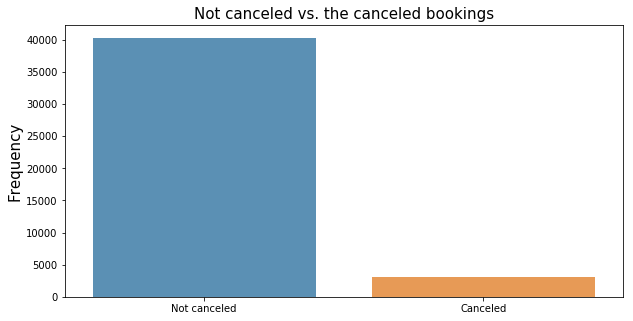

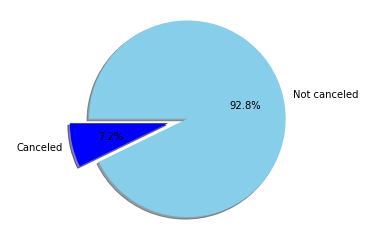

In [8]:
#Visual display for canceled vs. not canceled:

plt.figure(figsize=(10,5))
y = cancel.values
x= ['Not canceled','Canceled']
_= sns.barplot(x,y,alpha=0.8)
plt.title('Not canceled vs. the canceled bookings',fontsize=15)
plt.ylabel('Frequency', fontsize=15)
#plt.xlabel('', fontsize=12)
plt.show()



#pie plot showing the cancelled vs. not cancelled:

labels = 'Canceled','Not canceled'
sizes = [3132, 40299]
colors = ['blue', 'skyblue']
explode = (0.2, 0)  # explode 1st slice

#Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=180)

plt.axis('equal')
plt.show()

So, there is major class imbalance in the data. Very few cancellations are there as compared to the large amount of non-cancellations. We can see, only ~7% (only 3132, in total 43,431) of the total booking has been cancelled.

In [9]:
## Let's split the dataframe in another group (for which the car_cancellation =1):

df1 = df[df['Car_Cancellation'] > 0]
#df1.head()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3132 entries, 21 to 43422
Data columns (total 20 columns):
id                     3132 non-null int64
user_id                3132 non-null int64
vehicle_model_id       3132 non-null int64
package_id             336 non-null float64
travel_type_id         3132 non-null int64
from_area_id           3130 non-null float64
to_area_id             2775 non-null float64
from_city_id           1691 non-null float64
to_city_id             21 non-null float64
from_date              3132 non-null datetime64[ns]
to_date                2135 non-null datetime64[ns]
online_booking         3132 non-null int64
mobile_site_booking    3132 non-null int64
booking_created        3132 non-null datetime64[ns]
from_lat               3130 non-null float64
from_long              3130 non-null float64
to_lat                 2775 non-null float64
to_long                2775 non-null float64
Car_Cancellation       3132 non-null int64
Cost_of_error          3132 non-

So, df1 is another dataframe for the canceled ('Car_cancellation' = 1) bookings. Total no of entries are 3132.

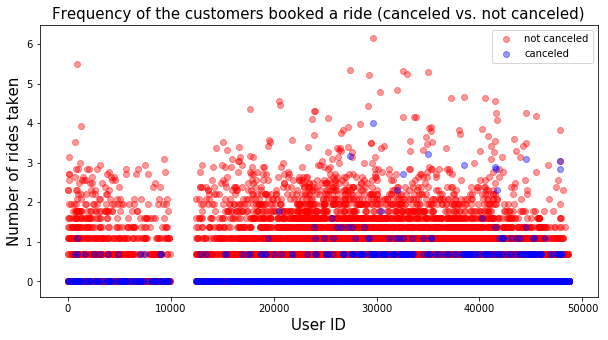

In [10]:
#Let's see how many users returned for the service
c=df.user_id.value_counts()
user_can=df1.user_id.value_counts()
#print(c)


plt.figure(figsize=(10,5))
_=plt.scatter(x=c.index,y=np.log(c.values),alpha=0.4,color='r',label='not canceled')
_=plt.scatter(x=user_can.index,y=np.log(user_can.values),alpha=0.4,color='b',label='canceled')
plt.title('Frequency of the customers booked a ride (canceled vs. not canceled)',fontsize=15)
plt.ylabel('Number of rides taken', fontsize=15)
plt.xlabel('User ID', fontsize=15)
plt.legend()
plt.show()

* So, we can see, the user with the user_id '29648' is the most frequent user, with frequency 471.  So, there are some returning customers and, some are the one time users. This data can be important for the marketing and sales group. <br/>

* We see that there is some gap/missing data in the user ID.

* The most frequent user (user_ID no '29648') got the maximum cancellations too, 55 times! The next most unfortunate user got his/her ride cancelled 25 times and so on.

* Notice, that taking log scale, the entire spectrum of the data is clearly visiable.

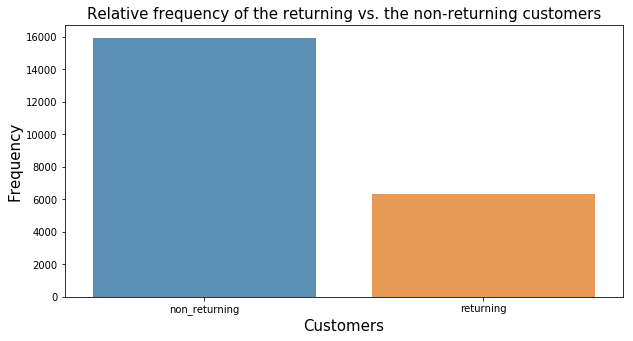

In [12]:
#Let's see how many customers are returning:

not_frequent= np.count_nonzero(c.values == 1)
is_frequent = np.count_nonzero(c.values >1)

#Let's see how many returning customers got their rides cancelled:
#freq_can=frequent_customers.index.intersection(user_can.index)


#print('No. of one time users (non returning) are: ' + str(not_frequent))
#print('No. of returning customers are:'+str(is_frequent))

#Visual display:

plt.figure(figsize=(10,5))
freq = [not_frequent, is_frequent]
index= ['non_returning','returning']
_=sns.barplot(index,freq,alpha=0.8)
plt.title('Relative frequency of the returning vs. the non-returning customers',fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Customers', fontsize=15)
plt.show()

So, we can see that the no. of one time users (non returning) are: 15935 and that of the returning are: 6332. 

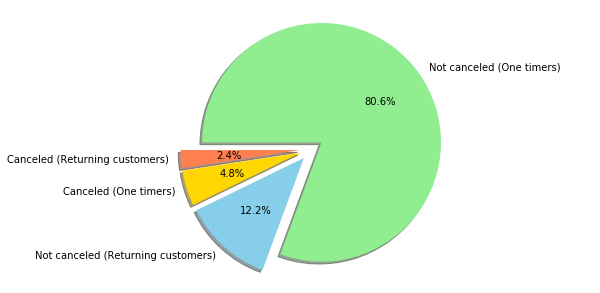

In [13]:
#following user IDs are the returning customers:
frequent_customers = c.loc[c.values>1]
#print(frequent_customers.index)
#Let's see how many returning customers got their rides cancelled:
freq_can=frequent_customers.index.intersection(user_can.index)

#visual representation
#pie plot showing the distribution:

plt.figure(figsize=(10,5))

labels = 'Canceled (Returning customers)','Canceled (One timers)','Not canceled (Returning customers)','Not canceled (One timers)'
sizes = [1049,2083,5283,35016]
colors = ['coral','gold', 'skyblue','lightgreen']
explode = (0.1,0.1,0.1,0.1)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=180)

plt.axis('equal')
plt.show()

What we see is, that 1049 unfortunate returning customers got their rides canceled. Number of total returning customers are 6332. So, roughly 16.6% of the total returning customers got their rides canceled.</br>
So, 5283 returning customers did not undergo any booking cancellation experiences.

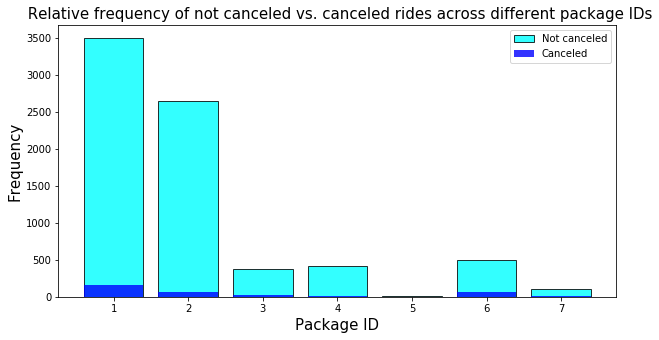

In [14]:
# Let's see the distribution of package_id
package=df.package_id.value_counts()
#print(package)
package_can=df1.package_id.value_counts()
#print(package_can.index)
#print(package_can.values)
#print(package.values)
#print(package.index)


#visual display
plt.figure(figsize=(10,5))
_=plt.bar(package.index,package.values,alpha=0.8,color='cyan',edgecolor='k',label='Not canceled')
_=plt.bar(package_can.index,package_can.values,alpha=0.8,color='b',label='Canceled')
plt.title(' Relative frequency of not canceled vs. canceled rides across different package IDs',fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Package ID', fontsize=15)
plt.legend()
plt.show()

So, what we see is, most of the packages people opt for are for a journey of 4hrs and around 40kms, followed by 8hrs and 80kms. (The description of different package IDs have been given above, in the description of the fields.) <br/>

We are trying to evaluate if the 'package_id' has much effect on the cancellation or not. Here in the same figure, we have plotted the same for the canceled bookings. Clearly, we can see that, most of the times package_ID no 1 gets cancelled.

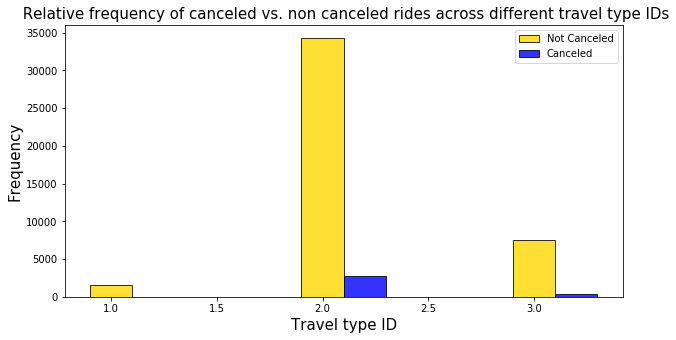

In [15]:
#Explore the distributions of different travel types:
travel = df.travel_type_id.value_counts()
#print(travel.values)
#print(travel.index)
tt= df1.travel_type_id.value_counts()
#print(tt.values)
#print(tt.index)

#Visually:

plt.figure(figsize=(10,5))
barwidth=0.2
_=plt.bar(travel.index,travel.values,alpha=0.8,color='gold',edgecolor='k',label='Not Canceled',width=barwidth)
_=plt.bar(tt.index+barwidth,tt.values,alpha=0.8,color='b',label='Canceled',width=barwidth,edgecolor='k')
plt.title(' Relative frequency of canceled vs. non canceled rides across different travel type IDs',fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Travel type ID', fontsize=15)
plt.legend()
plt.show()

So, from the barplot, what we see is, that the travel type '2' ( i.e. for point to point travel) is the most popular. (Again, the explaination of different travel type has been given above, in the description of data fields.) In the same figure, we have plotted the same for the cancelled bookings. Clearly, we see that, the most of the time travel type '2' types of bookings got canceled. The frequency of cancellation of travel type ID is so less, that it is almost not visiable here.


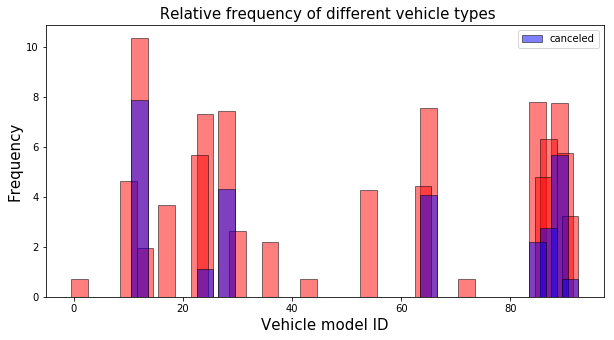

In [16]:
#Let's see different vehicle model type
vehicle=df.vehicle_model_id.value_counts()
vv=df1.vehicle_model_id.value_counts()
#print(vehicle.index)
#print(vehicle.values)
#print(vv.index)
#print(vv.values)


#visually
plt.figure(figsize=(10,5))
_=plt.bar(vehicle.index,np.log(vehicle.values),alpha=0.5,color='r',edgecolor='k',width=3)
_=plt.bar(vv.index,np.log(vv.values),alpha=0.5,color='b',edgecolor='k',width=3,label='canceled')
plt.title(' Relative frequency of different vehicle types',fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Vehicle model ID', fontsize=15)
plt.legend()
plt.show()

So, 27 different types of vehicles have been listed here. The most popular one is the vehicle with the vehicle ID no '12'. It has been used 31859 times. At the same time we see that the vehicle ID no '12' got the maximum number of cancellations, which is 2668 times. Notice, that after rescaling the values by taking the logarithm, gives a total picture of the entire spectrum of the data.

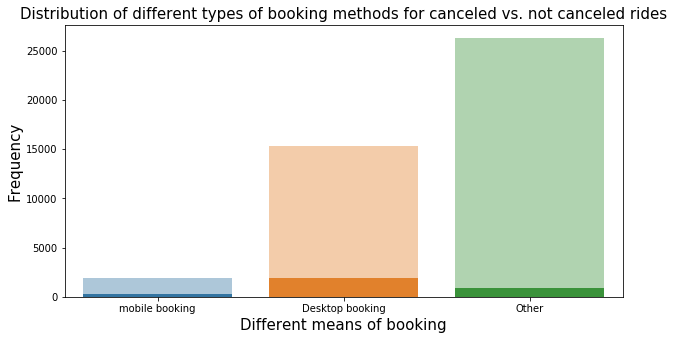

In [17]:
#Exploring the different ways of booking:
mobile= df.mobile_site_booking.value_counts()
mobile_can=df1.mobile_site_booking.value_counts()
#print(mobile.values)
#print(mobile.index)
#print(mobile_can.values)
#print(mobile_can.index)

online= df.online_booking.value_counts()
online_can=df1.online_booking.value_counts()
#print(online.values)
#print(online.index)
#print(online_can.values)
#print(online_can.index)

x= ['mobile booking','Desktop booking','Other']
y=[1878,15270,26283]
y_can=[289,1903,940]
plt.figure(figsize=(10,5))
_=sns.barplot(x,y,alpha=0.4)
_=sns.barplot(x,y_can,alpha=1)
plt.title('Distribution of different types of booking methods for canceled vs. not canceled rides',fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Different means of booking', fontsize=15)
plt.show()

So, we see that 1878 bookings have been done from the mobile websites, 15270 bookings from desktop websites, so, clearly 26283 bookings have been done differently! (Total no. of bookings=43431) So, the other methods of booking are mostly popular. though, nothing has been stated about that.<br/>

In the same figure we have shown the same plot for the canceled bookings (with deeper shades). Interestinly, this time the maximum frequency of cancellations correspond to the bookings done from desktop websites.

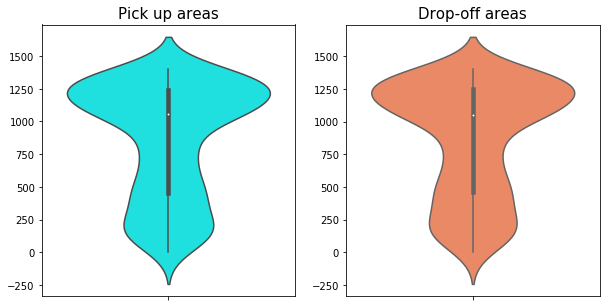

In [18]:
#Let's explore the area information

from_area=df.from_area_id.value_counts()
#print(from_area.index)
#print(from_area.values)

to_area= df.to_area_id.value_counts()
#print(to_area.index)
#print(to_area.values)

#Common between the two areas:
comm_area=set(df['from_area_id']).intersection(set(df['to_area_id']))
comm_area_list=list(comm_area)
#print(len(comm_area))

#Visually: Violinplot

plt.figure(figsize=(10,5))
plt.subplot(121)
ax1= sns.violinplot(from_area.index,color='cyan',orient='v')
plt.title('Pick up areas',fontsize=15)
plt.subplot(122)
ax2=sns.violinplot(to_area.index,color='coral',orient='v')
plt.title('Drop-off areas',fontsize=15)
plt.show()

So, 598 unique origin area and 568 destination area informations have been listed. We can see that the most popular origin area is the area with area_id no. '393', which is eventually the most popular destination area as well. We see, that 559 unique area IDs are listed as common to both the pick-up or the drop-off locations. <br />

The violinplots show both the pick-up and the drop-off area distributions. 


In [86]:
#Lets see if there is any relationship between the pickup area with car cancellation:

from_area_can = df.groupby(['from_area_id', 'Car_Cancellation']).size().unstack(1)
#from_area_can.head(10)
from_area_can['from_area_percent_canceled'] = (from_area_can[1] / (from_area_can[1] + from_area_can[0])) * 100

from_area_max_can= from_area_can.from_area_percent_canceled.sort_values(ascending=False).iloc[:20]
#area_can.percent_canceled.sort_values(ascending=False)

print(from_area_max_can)

from_area_id
130.0     80.000000
1148.0    66.666667
1174.0    66.666667
630.0     66.666667
176.0     52.830189
1381.0    50.000000
1160.0    50.000000
1100.0    50.000000
1385.0    50.000000
1276.0    45.454545
211.0     44.444444
1372.0    40.000000
356.0     40.000000
987.0     40.000000
626.0     34.375000
1258.0    33.333333
34.0      33.333333
326.0     33.333333
177.0     33.333333
833.0     33.333333
Name: from_area_percent_canceled, dtype: float64


So, we can see that there are certain pick-up areas for which more than 50% of the bookings were cancelled.

In [87]:
#Similar operation with the drop-off area:

to_area_can= df.groupby(['to_area_id','Car_Cancellation']).size().unstack(1)
#to_area_can.head(10)
to_area_can['to_area_percent_canceled'] = (to_area_can[1] / (to_area_can[1] + to_area_can[0])) * 100
to_area_max_can= to_area_can.to_area_percent_canceled.sort_values(ascending=False).iloc[:20]
print(to_area_max_can)

to_area_id
1247.0    75.000000
677.0     66.666667
355.0     66.666667
1218.0    60.000000
845.0     60.000000
1310.0    50.000000
1311.0    50.000000
1387.0    50.000000
1197.0    50.000000
1225.0    50.000000
1193.0    50.000000
1235.0    50.000000
598.0     50.000000
1357.0    50.000000
1336.0    50.000000
118.0     50.000000
122.0     41.463415
626.0     40.000000
520.0     40.000000
525.0     40.000000
Name: to_area_percent_canceled, dtype: float64


Similarly, we can see that there are certain drop-off areas for which more than 50% of the bookings were cancelled.

In [21]:
#Now explore the routes and the cancellations:

from_to_can = df.groupby(['from_area_id', 'to_area_id', 'Car_Cancellation']).size().unstack(2)
#from_to_can.head(10)
from_to_can['from_to_percent_cancelled'] = (from_to_can[1] / (from_to_can[0] + from_to_can[1])) * 100
from_to_route_max_can=from_to_can.from_to_percent_cancelled.sort_values(ascending=False).iloc[:20]
print(from_to_route_max_can)

from_area_id  to_area_id
626.0         122.0         90.909091
1349.0        1052.0        83.333333
1330.0        176.0         80.000000
1052.0        1349.0        78.571429
625.0         452.0         75.000000
1296.0        793.0         75.000000
1365.0        293.0         75.000000
1285.0        61.0          70.588235
122.0         626.0         70.000000
176.0         136.0         66.666667
1068.0        352.0         66.666667
264.0         585.0         66.666667
1384.0        160.0         66.666667
839.0         585.0         66.666667
571.0         396.0         66.666667
83.0          176.0         66.666667
1095.0        25.0          66.666667
363.0         1068.0        66.666667
542.0         1237.0        66.666667
541.0         83.0          66.666667
Name: from_to_percent_cancelled, dtype: float64


So, this is very interesting to see that some routes are very popular in terms of cancellations ; the cancellation rate for them is pretty high. As an example, the route from area ID: 626 to area ID: 122, almost 91% of the bookings were cancelled. 

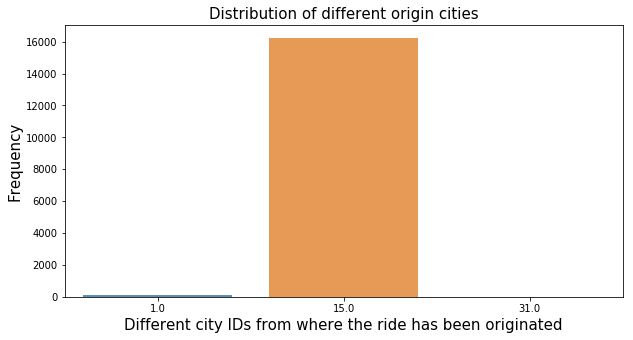

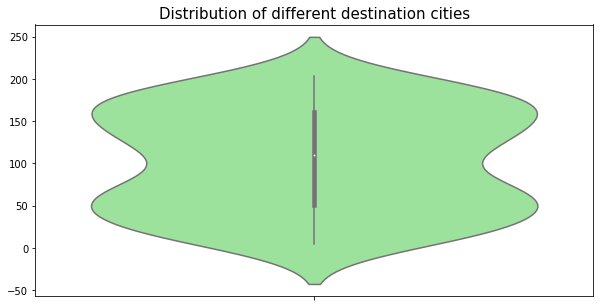

In [22]:
#Let's examine the cities:

from_city=df.from_city_id.value_counts()
#print(from_city.index)
#print(from_city.values)
to_city=df.to_city_id.value_counts()
#print(to_city.index)
#print(to_city.values)

#Visual representation
plt.figure(figsize=(10,5))
_=sns.barplot(from_city.index,from_city.values,alpha=0.8)
plt.title('Distribution of different origin cities',fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Different city IDs from where the ride has been originated', fontsize=15)
plt.show()

plt.figure(figsize=(10,5))
plt.title('Distribution of different destination cities',fontsize=15)
_= sns.violinplot(to_city.index,orient='v',color='lightgreen')
plt.show()

So, we can see that only 3 origin cities have been recorded. The most popular origin city is the city with the ID no: '15'. Where as, the destination cities are distributed in numbers. 116 unique destination cities have been recorded. The most popular destination city is the city with the ID no: '32' (475 rides have their destinations to this city.)

However, we need to rememeber that, only 16345 non-null values are available in 'from_city_id' information and 1588 non-null values are available in 'to_city_id' information. So, most of the informations are missing.

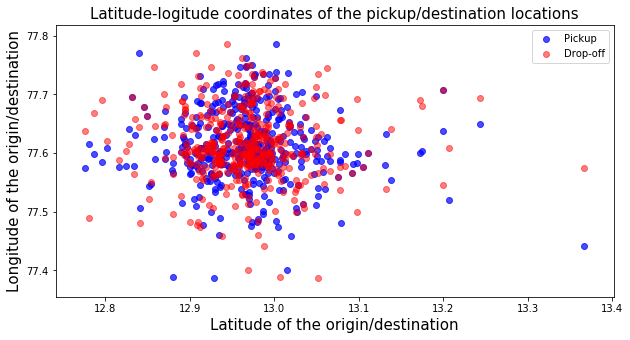

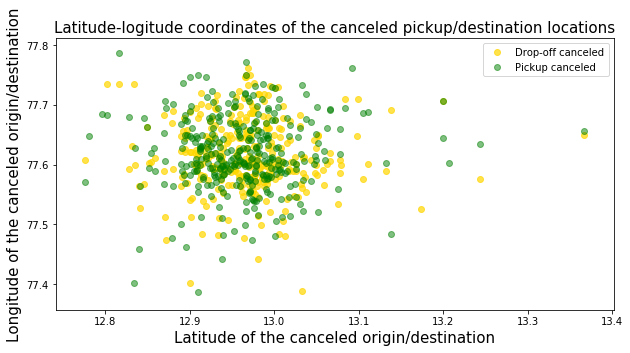

In [23]:
#Latitute-Longitude info and the cancellation:

#From_Lat
f_lat=df.from_lat.value_counts()
f_lat_can=df1.from_lat.value_counts()
f_lat_can_n=f_lat_can.index[:334,]
f_lat_n=f_lat.index[:462,]
#print(len(f_lat_can_n.values))

#From_Long
#f= from_area.index[:10,]
f_long=df.from_long.value_counts()
f_long_can=df1.from_long.value_counts()
#print(len(f_long_can.values))

#To_Lat
t_lat=df.to_lat.value_counts()
t_lat_n=t_lat.index[:447,]
t_lat_can=df1.to_lat.value_counts()
t_lat_can_n=t_lat_can.index[:336,]
#print(len(t_lat_can_n.values))

#To_Long
t_long=df.to_long.value_counts()
t_long_can=df1.to_long.value_counts()
#print(len(t_long_can.values))


#visually:
plt.figure(figsize=(10,5))
_=plt.scatter(x=f_lat_n,y=f_long.index,alpha=0.7,color='blue',label='Pickup')
_=plt.scatter(x=t_lat_n,y=t_long.index,alpha=0.5,color='r',label='Drop-off')

plt.title('Latitude-logitude coordinates of the pickup/destination locations',fontsize=15)
plt.ylabel('Longitude of the origin/destination', fontsize=15)
plt.xlabel('Latitude of the origin/destination', fontsize=15)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
_=plt.scatter(x=t_lat_can_n,y=t_long_can.index,alpha=0.7,color='gold',label='Drop-off canceled')
_=plt.scatter(x=f_lat_can_n,y=f_long_can.index,alpha=0.5,color='g',label='Pickup canceled')
plt.title('Latitude-logitude coordinates of the canceled pickup/destination locations',fontsize=15)
plt.ylabel('Longitude of the canceled origin/destination', fontsize=15)
plt.xlabel('Latitude of the canceled origin/destination', fontsize=15)
plt.legend()
plt.show()

In [24]:
#Latitude-longitude combo for maximum cancellations:

from_LL_can = df.groupby(['from_lat', 'from_long', 'Car_Cancellation']).size().unstack(2)
#from_LL_can.head(10)
from_LL_can['percent_cancelled_from_LL'] = (from_LL_can[1] / (from_LL_can[0] + from_LL_can[1])) * 100
from_LL_max_can=from_LL_can.percent_cancelled_from_LL.sort_values(ascending=False).iloc[:10]
print(from_LL_max_can)


to_LL_can = df.groupby(['to_lat', 'to_long', 'Car_Cancellation']).size().unstack(2)
#from_LL_can.head(10)
to_LL_can['percent_cancelled_to_LL'] = (to_LL_can[1] / (to_LL_can[0] + to_LL_can[1])) * 100
to_LL_max_can=to_LL_can.percent_cancelled_to_LL.sort_values(ascending=False).iloc[:10]
print(to_LL_max_can)

from_lat   from_long
12.907300  77.695120    52.830189
12.796650  77.386930    50.000000
12.895314  77.461074    50.000000
12.891277  77.458760    50.000000
12.928360  77.683958    45.454545
13.049670  77.604790    44.444444
13.366072  77.683112    40.000000
12.833854  77.400913    40.000000
12.967500  77.608130    33.333333
12.958620  77.696020    33.333333
Name: percent_cancelled_from_LL, dtype: float64
to_lat     to_long  
12.975390  77.548048    66.666667
12.980360  77.579940    60.000000
12.932229  77.690567    50.000000
12.956163  77.734160    50.000000
12.916941  77.589051    50.000000
12.980470  77.483730    50.000000
12.974967  77.614915    50.000000
12.988325  77.594263    50.000000
12.996820  77.604360    41.463415
12.934312  77.601508    40.000000
Name: percent_cancelled_to_LL, dtype: float64


So, again we see that, there are certain areas (latitude-logtitude combination), for which the pick-up/drop-off cancellations are high.

Maximum booking created at a given timestamp:18
And the corresponding date-time is: 2013-10-31 10:30:00
Minimum booking created at a given timestamp:1


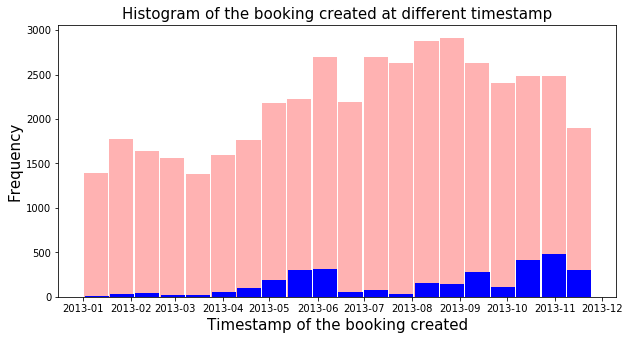

In [25]:
#Booking time:

time=df.booking_created.value_counts()
t=df.booking_created
t_can=df1.booking_created
time_can= df1.booking_created.value_counts()
#print(time_can)

max=time.values.max()
min=time.values.min()



#t=time.loc[time.values == max]

print('Maximum booking created at a given timestamp:'+ str(max))
print('And the corresponding date-time is: 2013-10-31 10:30:00')
print('Minimum booking created at a given timestamp:'+str(min))

#visually:
plt.figure(figsize=(10, 5))
#sns.set()
_=plt.hist(t,color='r',alpha=0.3,bins=20,rwidth=0.95)
_=plt.hist(t_can,color='b',alpha=1.0,bins=20,rwidth=0.95)
#plt.grid(axis='y', alpha=0.75)
plt.xlabel('Timestamp of the booking created',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Histogram of the booking created at different timestamp',fontsize=15)
plt.show()

Histogram is drawn to show the distribution of different booking time stamp frequencies (lighter shade). At the same graph, we have plotted the same which got canceled (darker shade).

Maximum trip started at a given timestamp:20
And the corresponding date-time is: 2013-10-12 06:00:00 and 2013-07-04 22:15:00
Minimum trip started at a given timestamp:1


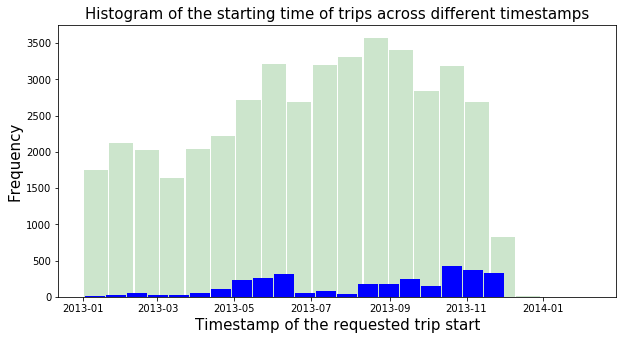

In [26]:
date=df.from_date.value_counts()
date_can=df1.from_date.value_counts()
#print(date_can)
d=df.from_date
d_can=df1.from_date
max_d=date.values.max()
min_d=date.values.min()

print('Maximum trip started at a given timestamp:'+ str(max_d))
print('And the corresponding date-time is: 2013-10-12 06:00:00 and 2013-07-04 22:15:00')
print('Minimum trip started at a given timestamp:'+str(min_d))

plt.figure(figsize=(10, 5))
_=plt.hist(d, color='g',alpha=0.2,bins=20,rwidth=0.95)
_=plt.hist(d_can,color='b',alpha=1.0,bins=20,rwidth=0.95)
#plt.grid(axis='y', alpha=0.75)
plt.xlabel('Timestamp of the requested trip start',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Histogram of the starting time of trips across different timestamps',fontsize=15)
plt.show()

In [27]:
d_can.describe()

count                    3132
unique                   2377
top       2013-05-12 07:30:00
freq                       11
first     2013-01-01 18:30:00
last      2013-11-30 18:30:00
Name: from_date, dtype: object

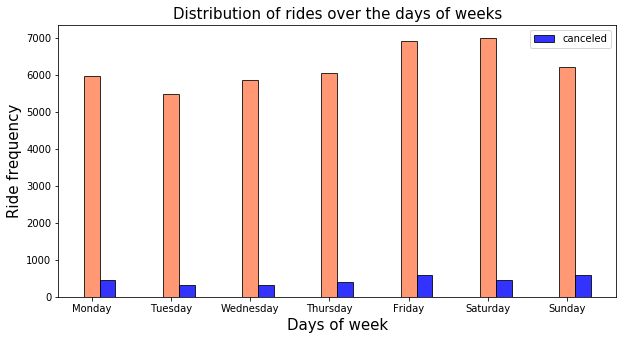

In [70]:
#Splitting the trip starting time info into two seperate columns, date and time:
#To see if that has any connection with the cancellations:

#pd.__version__
import datetime

df['date'] = pd.to_datetime(df['from_date'],errors= 'coerce').dt.dayofweek
df['month'] = pd.to_datetime(df['from_date'],errors= 'coerce').dt.month
df['time'] = pd.to_datetime(df['from_date'],errors ='coerce').dt.time

df1['date_can'] = pd.to_datetime(df['from_date'],errors= 'coerce').dt.dayofweek
df1['month_can'] = pd.to_datetime(df['from_date'],errors= 'coerce').dt.month
df1['time_can'] = pd.to_datetime(df['from_date'],errors ='coerce').dt.time


weekday=df.date.value_counts()
month=df.month.value_counts()
t=df.time.value_counts()
weekday_can=df1.date_can.value_counts()
month_can=df1.month_can.value_counts()
t_can=df1.time_can.value_counts()

#Visually days over the week:
plt.figure(figsize=(10, 5))
_=plt.bar(weekday.index,weekday.values,width=0.2,color='coral',edgecolor='k',alpha=0.8)
_=plt.bar(weekday_can.index+0.2,weekday_can.values,width=0.2,color='b',edgecolor='k',alpha=0.8,label='canceled')
plt.xlabel('Days of week',fontsize=15)
plt.xticks([0, 1, 2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

plt.ylabel('Ride frequency',fontsize=15)
plt.title('Distribution of rides over the days of weeks',fontsize=15)
plt.legend()
plt.show()

Here we have extracted the ride frequency over the days of the weeks. It seems they are almost equally distributed. Here '0' is equivalent to 'Monday' and so on. We see that the maximum frequency (6990) of rides correspond to day no '5', i.e. 'saturday', followed by the day no '4', which is the 'friday'. So, people book cabs more in the weekends.

On the same figure we have plotted the canceled ride friequencies. And they seem to appear equally distributed over the days of the weeks. However, the maximum cancellations(578) correspond to the day no '4', which is 'friday', followed by the day no '6', which is 'sunday'.

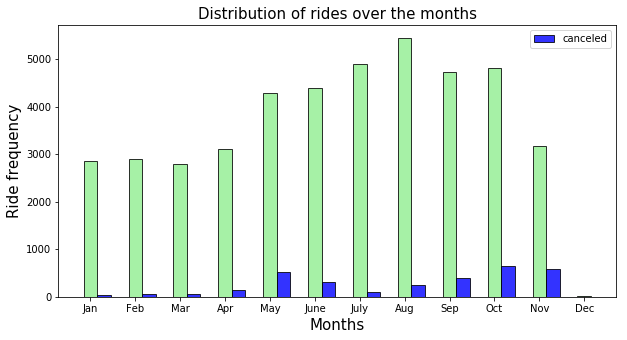

In [71]:
#Visually months over the year:
plt.figure(figsize=(10, 5))
_=plt.bar(month.index,month.values,width=0.3,color='lightgreen',edgecolor='k',alpha=0.8)
_=plt.bar(month_can.index+0.3,month_can.values,width=0.3,color='b',edgecolor='k',alpha=0.8,label='canceled')
plt.xlabel('Months',fontsize=15)
plt.ylabel('Ride frequency',fontsize=15)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec'])
plt.title('Distribution of rides over the months',fontsize=15)
plt.legend()
plt.show()

Here we have extracted the ride frequency over the months of the year. We see that the maximum frequency (5445) corresponds to the month no '8', which is the month of 'August', followed by 'July'. 

On the same figure we have plotted the canceled ride friequencies. Maximum cancellation (650) correspond to the month no '10', which is 'October', followed by 'November'. 

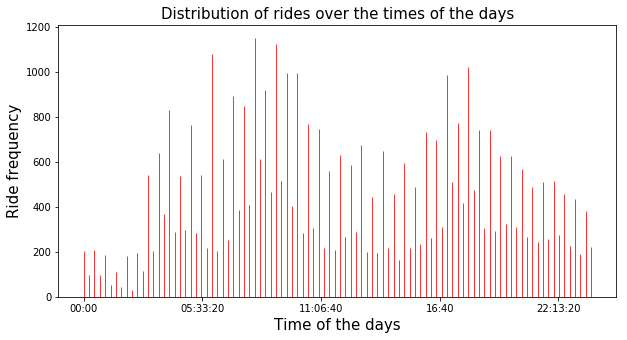

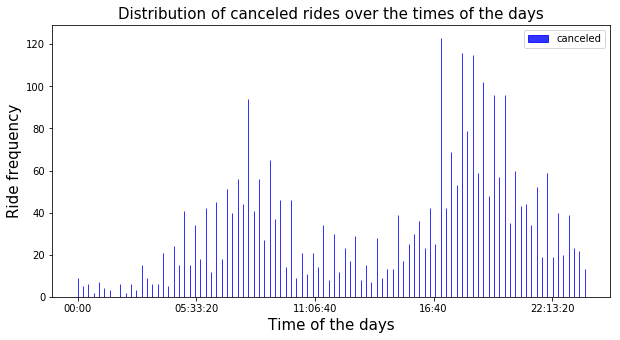

In [47]:
#Visually time of the day 
plt.figure(figsize=(10, 5))
_=plt.bar(t.index,t.values,color='g',alpha=0.8,width=0.2,edgecolor='r')
#_=plt.bar(t_can.index,t_can.values,width=0.2,color='b',edgecolor='k',alpha=0.8,label='canceled')
plt.xlabel('Time of the days',fontsize=15)
#plt.xticks(labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.ylabel('Ride frequency',fontsize=15)
plt.title('Distribution of rides over the times of the days',fontsize=15)
#plt.legend()
plt.show()

#Visually time of the day 
plt.figure(figsize=(10, 5))
#_=plt.bar(t.index,t.values,color='g',alpha=0.8,width=0.2,edgecolor='r')
_=plt.bar(t_can.index,t_can.values,width=0.2,color='b',edgecolor='b',alpha=0.8,label='canceled')
plt.xlabel('Time of the days',fontsize=15)
#plt.xticks(labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.ylabel('Ride frequency',fontsize=15)
plt.title('Distribution of canceled rides over the times of the days',fontsize=15)
plt.legend()
plt.show()

Here clearly we can see the two humps/clusters in the distributions of the ride frequencies. So, what we see is that, the maximum rides are booked for two typical time stamps in a given day. One is around the morning and another for the evening time. Clearly these two are the busiest hours, or mostly what we call as the 'office time' rush' in a day. 

The ride cancellation distribution also follows the same trend. Maximum numbers of rides got canceled in these two peak hours. As obvious, these are the times, when rides can get canceled due to unavailibility of cars.

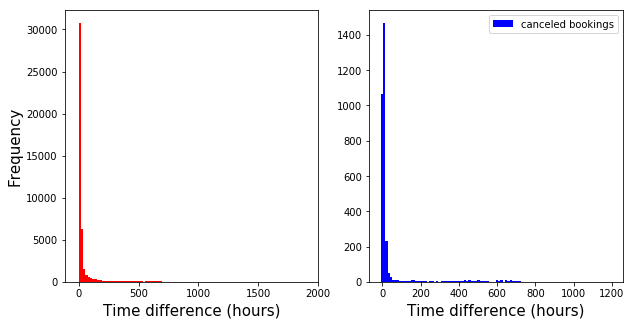

In [76]:
#Inspect if the time difference between the time of 
#booking and the time of trip strat has any impact on the cancellation:

import datetime as dt
end= df['from_date']
start=df['booking_created']
diff = (end - start) 
df['time_difference']= diff/np.timedelta64(1,'h')
#print(difference)


end= df1['from_date']
start=df1['booking_created']
diff_can = (end - start) 
df1['time_difference_can']= diff_can/np.timedelta64(1,'h')
#print(difference)

#Visually:
plt.figure(figsize=(10,5))
plt.subplot(121)
ax1=plt.hist(df['time_difference'],bins=100,color='r')
plt.xlabel('Time difference (hours)',fontsize=15)
plt.ylabel('Frequency',fontsize=15)

plt.subplot(122)
ax2=plt.hist(df1['time_difference_can'],bins=100,label='canceled bookings',color='b')
plt.xlabel('Time difference (hours)',fontsize=15)
#plt.ylabel('Frequency',fontsize=15)
plt.legend()
plt.show()

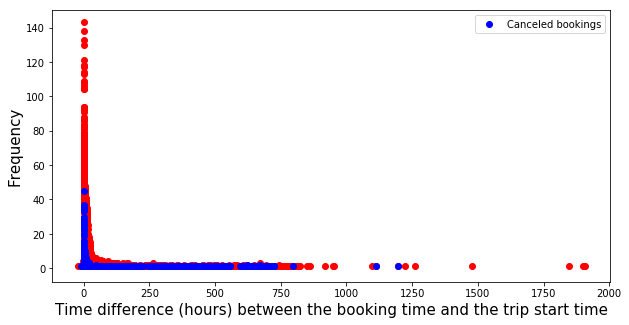

In [78]:
td=df.time_difference.value_counts()
td_can=df1.time_difference_can.value_counts()
plt.figure(figsize=(10,5))
_=plt.scatter(td.index,td.values,color='r')
_=plt.scatter(td_can.index,td_can.values,color='b',label='Canceled bookings')
plt.xlabel('Time difference (hours) between the booking time and the trip start time',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.legend()
plt.show()

'Time difference' (in hours) is a new feature, which is the difference between the time when the ride was booked and the actual starting time of the trip. There seems to be no relation between the time difference and the cancellation. 